In [ ]:
import itertools
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from jk_utils import (
    construct_vandermonde,
    jacobi_gauss_lobatto,
    jacobi_polynomial,
    grad_jacobi_polynomial,
    trigonometric_polynomial_centered,
)
from common import setup_plotting, PAPER_WIDTH_IN, OUTPUT_DIR, EXPORT_DPI

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
setup_plotting()

# b)
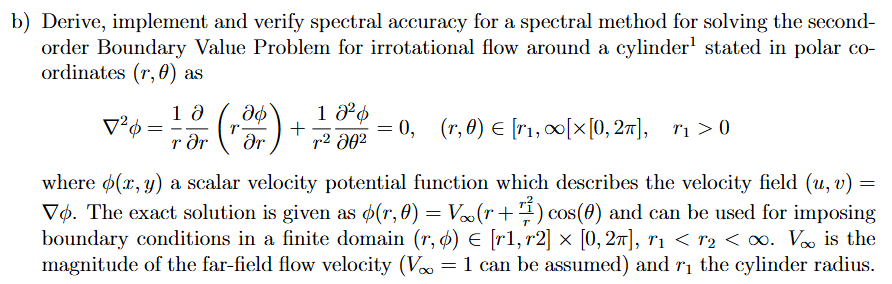

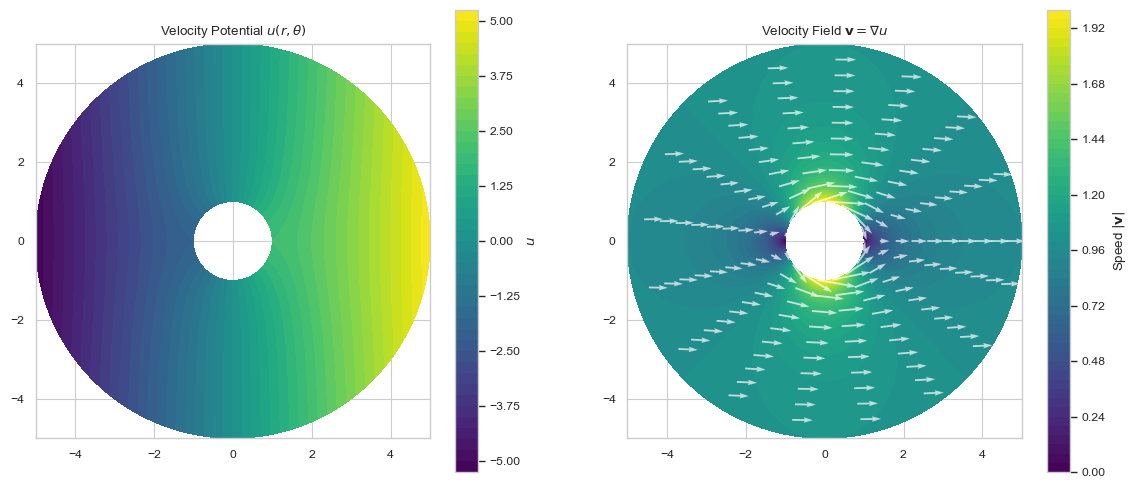

In [42]:
# Canonical Laplacian operator, so in cartesians it is simply pdv(ϕ, x, 2) + pdv(ϕ, y, 2) = 0
# Known parameters
V_inf = 1.0
r_1 = 1.0  # I came up with this one
r_2 = 5.0  # I came up with this one


def u_func_2_rtheta(r, theta):
    return V_inf * (r + r_1**2 / r) * np.cos(theta)


def u_func_2_xy(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return u_func_2_rtheta(r, theta)


def transform2xy(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y


def transform2rtheta(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta


# Start by plotting the true solution
r_true = np.linspace(r_1, r_2, 500)
theta_true = np.linspace(0, 2 * np.pi, 500)
R_true, Theta_true = np.meshgrid(r_true, theta_true)
U_true = u_func_2_rtheta(R_true, Theta_true)

# Get velocities
V_r = np.gradient(U_true, r_true, axis=1)  # derivative along r direction
V_theta = (
    np.gradient(U_true, theta_true, axis=0) / R_true
)  # derivative along theta direction

# Convert to Cartesian grid for plotting
X_true = R_true * np.cos(Theta_true)
Y_true = R_true * np.sin(Theta_true)

# Convert to Cartesian velocities
V_x = V_r * np.cos(Theta_true) - V_theta * np.sin(Theta_true)
V_y = V_r * np.sin(Theta_true) + V_theta * np.cos(Theta_true)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
contour1 = ax1.contourf(X_true, Y_true, U_true, levels=50, cmap="viridis")
ax1.set_aspect("equal")
ax1.set_title("Velocity Potential $u(r,\\theta)$")
plt.colorbar(contour1, ax=ax1, label="$u$")

# Velocity magnitude with streamlines
speed = np.sqrt(V_x**2 + V_y**2)
contour2 = ax2.contourf(X_true, Y_true, speed, levels=50, cmap="viridis")
skip_x = 30
skip_y = 50
ax2.quiver(
    X_true[::skip_x, ::skip_y],
    Y_true[::skip_x, ::skip_y],
    V_x[::skip_x, ::skip_y],
    V_y[::skip_x, ::skip_y],
    color="white",
    alpha=0.7,
    scale=20,
)
ax2.set_aspect("equal")
ax2.set_title("Velocity Field $\\mathbf{v} = \\nabla u$")
plt.colorbar(contour2, ax=ax2, label="Speed $|\\mathbf{v}|$")

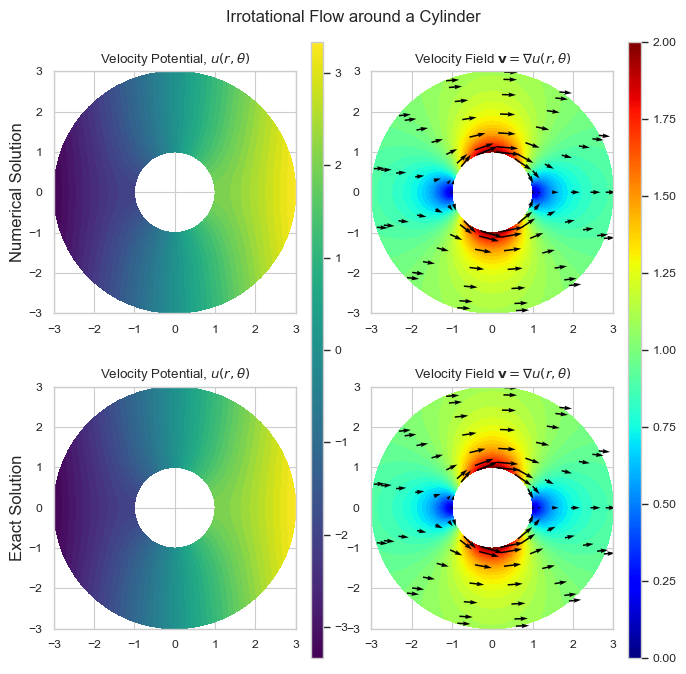

In [43]:
# We must need to do a really strange mapping since z=-1 -> r_1, z=1 -> r_2

# Discretisation parameters
N_r_grid = 32  # Nodes in r direction
N_theta_grid = 64  # Nodes in theta direction
N_r = N_r_grid - 1  # Polynomial degree in r direction
N_theta = N_theta_grid - 1  # Polynomial degree in theta direction

# Constants for the problem
V_inf = 1.0
r_1 = 1.0  # I came up with this one
r_2 = 3.0  # I came up with this one
L_theta = 2 * np.pi  # Domain length in theta direction

# Jacobi parameters for r direction
alpha_r = 0.0
beta_r = 0.0

# Get nodes for both dimensions
z_r, w_r = jacobi_gauss_lobatto(N_r, alpha_r, beta_r)
z_theta = np.linspace(
    0.0, 2 * np.pi, N_theta_grid, endpoint=False
)  # Equidistant in theta

# Set up basis functions
basis_func_r = partial(jacobi_polynomial, alpha=alpha_r, beta=beta_r)
basis_func_r_grad = partial(grad_jacobi_polynomial, alpha=alpha_r, beta=beta_r)
basis_func_theta = partial(
    trigonometric_polynomial_centered, k=0, N=N_theta_grid, L=L_theta
)
basis_func_theta_grad = partial(
    trigonometric_polynomial_centered, k=1, N=N_theta_grid, L=L_theta
)

# Get differentiation matrix in r direction
V_r = construct_vandermonde(z_r, N_r + 1, basis_func_r)
V_r_z = construct_vandermonde(z_r, N_r + 1, basis_func_r_grad)
D_r_z = np.linalg.solve(
    V_r.T, V_r_z.T
).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve

# Get differentiation matrix in theta direction
V_theta = construct_vandermonde(
    z_theta, N_theta_grid, basis_func_theta, dtype=np.complex128
)
V_theta_z = construct_vandermonde(
    z_theta, N_theta_grid, basis_func_theta_grad, dtype=np.complex128
)
D_theta_z = np.linalg.solve(
    V_theta.T, V_theta_z.T
).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve

# Set up transformation from z_r to r
r_r = (r_2 - r_1) / 2 * z_r + (r_1 + r_2) / 2  # Map to [r_1, r_2]
J_r = (r_2 - r_1) / 2  # Jacobian of the transformation z -> r
J_r_inv = 1 / J_r

R, Theta = np.meshgrid(r_r, z_theta, indexing="ij")
R_flat = R.flatten()
Theta_flat = Theta.flatten()

# Set up matrices for Laplacian
I_r = np.eye(N_r_grid)
I_theta = np.eye(N_theta_grid)
R_inv_diag = np.diag(1.0 / R_flat)
R_inv_sq_diag = np.diag(1.0 / R_flat**2)

# Create D using Kronecker products
D_z_full = np.kron(D_r_z, I_theta)
D_theta_full = np.kron(I_r, D_theta_z)

L_N = (
    (J_r_inv**2) * (D_z_full @ D_z_full)
    + R_inv_diag @ (J_r_inv * D_z_full)
    + R_inv_sq_diag @ (D_theta_full @ D_theta_full)
)

# Inner boundary
for j in range(N_theta_grid):
    idx = 0 * N_theta_grid + j  # First radial index
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

# Outer boundary (i=N_r-1, all theta)
for j in range(N_theta_grid):
    idx = (N_r_grid - 1) * N_theta_grid + j  # Last radial index
    L_N[idx, :] = 0.0
    L_N[idx, idx] = 1.0

N_total = N_r_grid * N_theta_grid
F = np.zeros(N_total)

# Set boundary values
for j in range(N_theta_grid):
    # Inner
    F[0 * N_theta_grid + j] = u_func_2_rtheta(r_1, z_theta[j])

    # Outer
    F[(N_r_grid - 1) * N_theta_grid + j] = u_func_2_rtheta(r_2, z_theta[j])

# Solve
u_flat = np.linalg.solve(L_N, F)
u_flat = np.real(
    u_flat
)  # Discard imaginary part, which is only due to numerical errors
u_numerical = u_flat.reshape((N_r_grid, N_theta_grid), order="C")

### Prepare for plot
u_exact = u_func_2_rtheta(R, Theta)

# This is for plotting to close the circle in theta
z_theta_plot = np.append(z_theta, 2 * np.pi)
u_numerical_plot = np.hstack([u_numerical, u_numerical[:, 0:1]])

R_plot, Theta_plot = np.meshgrid(r_r, z_theta_plot, indexing="ij")
u_exact_plot = u_func_2_rtheta(R_plot, Theta_plot)
X_plot = R_plot * np.cos(Theta_plot)
Y_plot = R_plot * np.sin(Theta_plot)


# Numerical - Potential
# Numerical - Field
V_r = J_r_inv * (D_r_z @ u_numerical)
V_theta = (1.0 / R) * (u_numerical @ D_theta_z.T)
V_theta = np.real(V_theta)  # Discard imaginary part

# Convert to Cartesian velocities
V_x = V_r * np.cos(Theta) - V_theta * np.sin(Theta)
V_y = V_r * np.sin(Theta) + V_theta * np.cos(Theta)

speed = np.sqrt(V_x**2 + V_y**2)

# Exact - Potential
# Exact - Field
V_r_exact = J_r_inv * (D_r_z @ u_exact)
V_theta_exact = (1.0 / R) * (u_exact @ D_theta_z.T)
V_theta_exact = np.real(V_theta_exact)  # Discard imaginary part

# Convert to Cartesian velocities
V_x_exact = V_r_exact * np.cos(Theta) - V_theta_exact * np.sin(Theta)
V_y_exact = V_r_exact * np.sin(Theta) + V_theta_exact * np.cos(Theta)

speed_exact = np.sqrt(V_x_exact**2 + V_y_exact**2)

# Plot
# Row 1: Numerical Solution
# Row 2: Exact Solution
# Column 1: Velocity Potential
# Column 2: Velocity Field

fig, axs = plt.subplots(2, 2, figsize=(PAPER_WIDTH_IN, PAPER_WIDTH_IN))
cmap_potential = plt.get_cmap("viridis")
cmap_field = plt.get_cmap("jet")
_potentials = [u_numerical, u_exact]
normalizer_potential = mpl.colors.Normalize(
    vmin=np.min(_potentials), vmax=np.max(_potentials)
)
_fields = [speed, speed_exact]
normalizer_field = mpl.colors.Normalize(vmin=np.min(_fields), vmax=np.max(_fields))

# Numerical - Potential
contour1 = axs[0, 0].contourf(
    X_plot,
    Y_plot,
    u_numerical_plot,
    levels=50,
    cmap=cmap_potential,
    norm=normalizer_potential,
)
axs[0, 0].set_title("Velocity Potential, $u(r,\\theta)$")
axs[0, 0].set_aspect("equal")

# Numerical - Field
# For plotting, append first column to the end to close the circle
speed_plot = np.hstack([speed, speed[:, 0:1]])
V_x_plot = np.hstack([V_x, V_x[:, 0:1]])
V_y_plot = np.hstack([V_y, V_y[:, 0:1]])
contour2 = axs[0, 1].contourf(
    X_plot, Y_plot, speed_plot, levels=50, cmap=cmap_field, norm=normalizer_field
)
skip_x = 5
skip_y = 5
axs[0, 1].quiver(
    X_plot[::skip_x, ::skip_y],
    Y_plot[::skip_x, ::skip_y],
    V_x_plot[::skip_x, ::skip_y],
    V_y_plot[::skip_x, ::skip_y],
    color="black",
    scale=20,
)
axs[0, 1].set_aspect("equal")
axs[0, 1].set_title("Velocity Field $\\mathbf{v} = \\nabla u(r, \\theta)$")

# Exact - Potential
contour1 = axs[1, 0].contourf(
    X_plot,
    Y_plot,
    u_exact_plot,
    levels=50,
    cmap=cmap_potential,
    norm=normalizer_potential,
)
axs[1, 0].set_title("Velocity Potential, $u(r,\\theta)$")
axs[1, 0].set_aspect("equal")

# Exact - Field
# For plotting, append first column to the end to close the circle
speed_plot_exact = np.hstack([speed_exact, speed_exact[:, 0:1]])
V_x_plot_exact = np.hstack([V_x_exact, V_x_exact[:, 0:1]])
V_y_plot_exact = np.hstack([V_y_exact, V_y_exact[:, 0:1]])
contour2 = axs[1, 1].contourf(
    X_plot, Y_plot, speed_plot_exact, levels=50, cmap=cmap_field, norm=normalizer_field
)
axs[1, 1].quiver(
    X_plot[::skip_x, ::skip_y],
    Y_plot[::skip_x, ::skip_y],
    V_x_plot_exact[::skip_x, ::skip_y],
    V_y_plot_exact[::skip_x, ::skip_y],
    color="black",
    scale=20,
)
axs[1, 1].set_aspect("equal")
axs[1, 1].set_title("Velocity Field $\\mathbf{v} = \\nabla u(r,\\theta)$")

fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Colorbars
im_potential = mpl.cm.ScalarMappable(norm=normalizer_potential, cmap=cmap_potential)
cbar_potential = fig.colorbar(im_potential, ax=[axs[0, 0], axs[1, 0]], aspect=50)
im_field = mpl.cm.ScalarMappable(norm=normalizer_field, cmap=cmap_field)
cbar_field = fig.colorbar(im_field, ax=[axs[0, 1], axs[1, 1]], aspect=50)
# Vertical titles
axs[0, 0].text(
    -0.15,
    0.5,
    "Numerical Solution",
    rotation="vertical",
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[0, 0].transAxes,
    size=12,
)
axs[1, 0].text(
    -0.15,
    0.5,
    "Exact Solution",
    rotation="vertical",
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[1, 0].transAxes,
    size=12,
)

fig.suptitle("Irrotational Flow around a Cylinder", y=0.92, fontsize=12)
fig.savefig(OUTPUT_DIR / "1_b.png", dpi=EXPORT_DPI, bbox_inches="tight")

In [71]:
# Check convergence
# Discretisation parameters
N_r_grids = np.arange(3, 30+1)
N_theta_grids = [1, 2, 4, 6]
data = []
for N_r_grid, N_theta_grid in itertools.product(N_r_grids, N_theta_grids):
    print(f"Solving for N_r={N_r_grid}, N_theta={N_theta_grid}")
    N_r = N_r_grid - 1  # Polynomial degree in r direction
    N_theta = N_theta_grid - 1  # Polynomial degree in theta direction

    # Constants for the problem
    V_inf = 1.0
    r_1 = 1.0  # I came up with this one
    r_2 = 3.0  # I came up with this one
    L_theta = 2 * np.pi  # Domain length in theta direction

    # Jacobi parameters for r direction
    alpha_r = 0.0
    beta_r = 0.0

    # Get nodes for both dimensions
    z_r, w_r = jacobi_gauss_lobatto(N_r, alpha_r, beta_r)
    z_theta = np.linspace(
        0.0, 2 * np.pi, N_theta_grid, endpoint=False
    )  # Equidistant in theta

    # Set up basis functions
    basis_func_r = partial(jacobi_polynomial, alpha=alpha_r, beta=beta_r)
    basis_func_r_grad = partial(grad_jacobi_polynomial, alpha=alpha_r, beta=beta_r)
    basis_func_theta = partial(
        trigonometric_polynomial_centered, k=0, N=N_theta_grid, L=L_theta
    )
    basis_func_theta_grad = partial(
        trigonometric_polynomial_centered, k=1, N=N_theta_grid, L=L_theta
    )

    # Get differentiation matrix in r direction
    V_r = construct_vandermonde(z_r, N_r + 1, basis_func_r)
    V_r_z = construct_vandermonde(z_r, N_r + 1, basis_func_r_grad)
    D_r_z = np.linalg.solve(
        V_r.T, V_r_z.T
    ).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve

    # Get differentiation matrix in theta direction
    V_theta = construct_vandermonde(
        z_theta, N_theta_grid, basis_func_theta, dtype=np.complex128
    )
    V_theta_z = construct_vandermonde(
        z_theta, N_theta_grid, basis_func_theta_grad, dtype=np.complex128
    )
    D_theta_z = np.linalg.solve(
        V_theta.T, V_theta_z.T
    ).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve

    # Set up transformation from z_r to r
    r_r = (r_2 - r_1) / 2 * z_r + (r_1 + r_2) / 2  # Map to [r_1, r_2]
    J_r = (r_2 - r_1) / 2  # Jacobian of the transformation z -> r
    J_r_inv = 1 / J_r

    R, Theta = np.meshgrid(r_r, z_theta, indexing="ij")
    R_flat = R.flatten()
    Theta_flat = Theta.flatten()

    # Set up matrices for Laplacian
    I_r = np.eye(N_r_grid)
    I_theta = np.eye(N_theta_grid)
    R_inv_diag = np.diag(1.0 / R_flat)
    R_inv_sq_diag = np.diag(1.0 / R_flat**2)

    # Create D using Kronecker products
    D_z_full = np.kron(D_r_z, I_theta)
    D_theta_full = np.kron(I_r, D_theta_z)

    L_N = (
        (J_r_inv**2) * (D_z_full @ D_z_full)
        + R_inv_diag @ (J_r_inv * D_z_full)
        + R_inv_sq_diag @ (D_theta_full @ D_theta_full)
    )

    # Inner boundary
    for j in range(N_theta_grid):
        idx = 0 * N_theta_grid + j  # First radial index
        L_N[idx, :] = 0.0
        L_N[idx, idx] = 1.0

    # Outer boundary (i=N_r-1, all theta)
    for j in range(N_theta_grid):
        idx = (N_r_grid - 1) * N_theta_grid + j  # Last radial index
        L_N[idx, :] = 0.0
        L_N[idx, idx] = 1.0

    N_total = N_r_grid * N_theta_grid
    F = np.zeros(N_total)

    # Set boundary values
    for j in range(N_theta_grid):
        # Inner
        F[0 * N_theta_grid + j] = u_func_2_rtheta(r_1, z_theta[j])

        # Outer
        F[(N_r_grid - 1) * N_theta_grid + j] = u_func_2_rtheta(r_2, z_theta[j])

    # Solve
    u_flat = np.linalg.solve(L_N, F)
    u_flat = np.real(
        u_flat
    )  # Discard imaginary part, which is only due to numerical errors
    u_numerical = u_flat.reshape((N_r_grid, N_theta_grid), order="C")

    ### Prepare for plot
    u_exact = u_func_2_rtheta(R, Theta)

    error_L2 = np.linalg.norm(u_numerical - u_exact, ord=2) / np.linalg.norm(u_exact, ord=2)
    error_L_inf = np.linalg.norm(u_numerical - u_exact, ord=np.inf) / np.linalg.norm(
        u_exact, ord=np.inf
    )
    data.append(
        {
            "N_r": N_r_grid,
            "N_theta": N_theta_grid,
            "error_L2": error_L2,
            "error_L_inf": error_L_inf,
        }
    )

Solving for N_r=3, N_theta=1
Solving for N_r=3, N_theta=2
Solving for N_r=3, N_theta=4
Solving for N_r=3, N_theta=6
Solving for N_r=4, N_theta=1
Solving for N_r=4, N_theta=2
Solving for N_r=4, N_theta=4
Solving for N_r=4, N_theta=6
Solving for N_r=5, N_theta=1
Solving for N_r=5, N_theta=2
Solving for N_r=5, N_theta=4
Solving for N_r=5, N_theta=6
Solving for N_r=6, N_theta=1
Solving for N_r=6, N_theta=2
Solving for N_r=6, N_theta=4
Solving for N_r=6, N_theta=6
Solving for N_r=7, N_theta=1
Solving for N_r=7, N_theta=2
Solving for N_r=7, N_theta=4
Solving for N_r=7, N_theta=6
Solving for N_r=8, N_theta=1
Solving for N_r=8, N_theta=2
Solving for N_r=8, N_theta=4
Solving for N_r=8, N_theta=6
Solving for N_r=9, N_theta=1
Solving for N_r=9, N_theta=2
Solving for N_r=9, N_theta=4
Solving for N_r=9, N_theta=6
Solving for N_r=10, N_theta=1
Solving for N_r=10, N_theta=2
Solving for N_r=10, N_theta=4
Solving for N_r=10, N_theta=6
Solving for N_r=11, N_theta=1
Solving for N_r=11, N_theta=2
Solving 

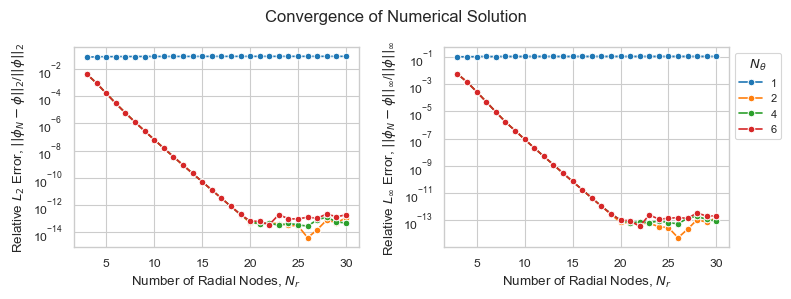

In [ ]:
df = pd.DataFrame(data)

fig, (ax_L2, ax_L_inf) = plt.subplots(1, 2, figsize=(PAPER_WIDTH_IN, 3))
sns.lineplot(df, ax=ax_L_inf, x="N_r", y="error_L_inf", hue="N_theta", marker="o", palette="tab10")
sns.lineplot(df, ax=ax_L2, x="N_r", y="error_L2", hue="N_theta", marker="o", palette="tab10")

ax_L2.semilogy()
ax_L_inf.semilogy()

fig.suptitle("Convergence of Numerical Solution", y=0.98, fontsize=12)

ax_L2.set_ylabel("Relative $L_2$ Error, $||ϕ_N - ϕ||_2$/$||ϕ||_2$")
ax_L_inf.set_ylabel("Relative $L_∞$ Error, $||ϕ_N - ϕ||_∞$/$||ϕ||_∞$")
ax_L2.set_xlabel("Number of Radial Nodes, $N_r$")
ax_L_inf.set_xlabel("Number of Radial Nodes, $N_r$")

ax_L2.legend().remove()
ax_L_inf.legend(title="$N_θ$", loc="upper left", fontsize=8, bbox_to_anchor=(1.0, 1.0))

fig.tight_layout()
fig.subplots_adjust(wspace=0.3)

fig.savefig(OUTPUT_DIR / "1_b_convergence.png", dpi=EXPORT_DPI, bbox_inches="tight")